In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

import scipy.stats as stats

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.metrics import (evaluate_multistep,
                                             calculate_rms, calculate_bias, 
                                             calculate_bias_flv, calculate_bias_fhv,
                                             calculate_bias, calculate_nse, calculate_kge,
                                            )
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})


In [2]:
def dt(dates, format="%d/%m/%Y %H:%M"):
    if dates.tz == None:
        # make TZ aware
        return pd.to_datetime(dates, format=format).tz_localize("Europe/London").tz_convert("UTC")
    else:
        return pd.to_datetime(dates, format=format).tz_convert("UTC")
   

In [3]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [4]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "black",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
              r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
              ls = "-",
              )
     }

arima
elstm
dictonary loaded
175/175 [==============================] - 2s 7ms/step
pbhm-hlstm
dictonary loaded
175/175 [==============================] - 2s 6ms/step


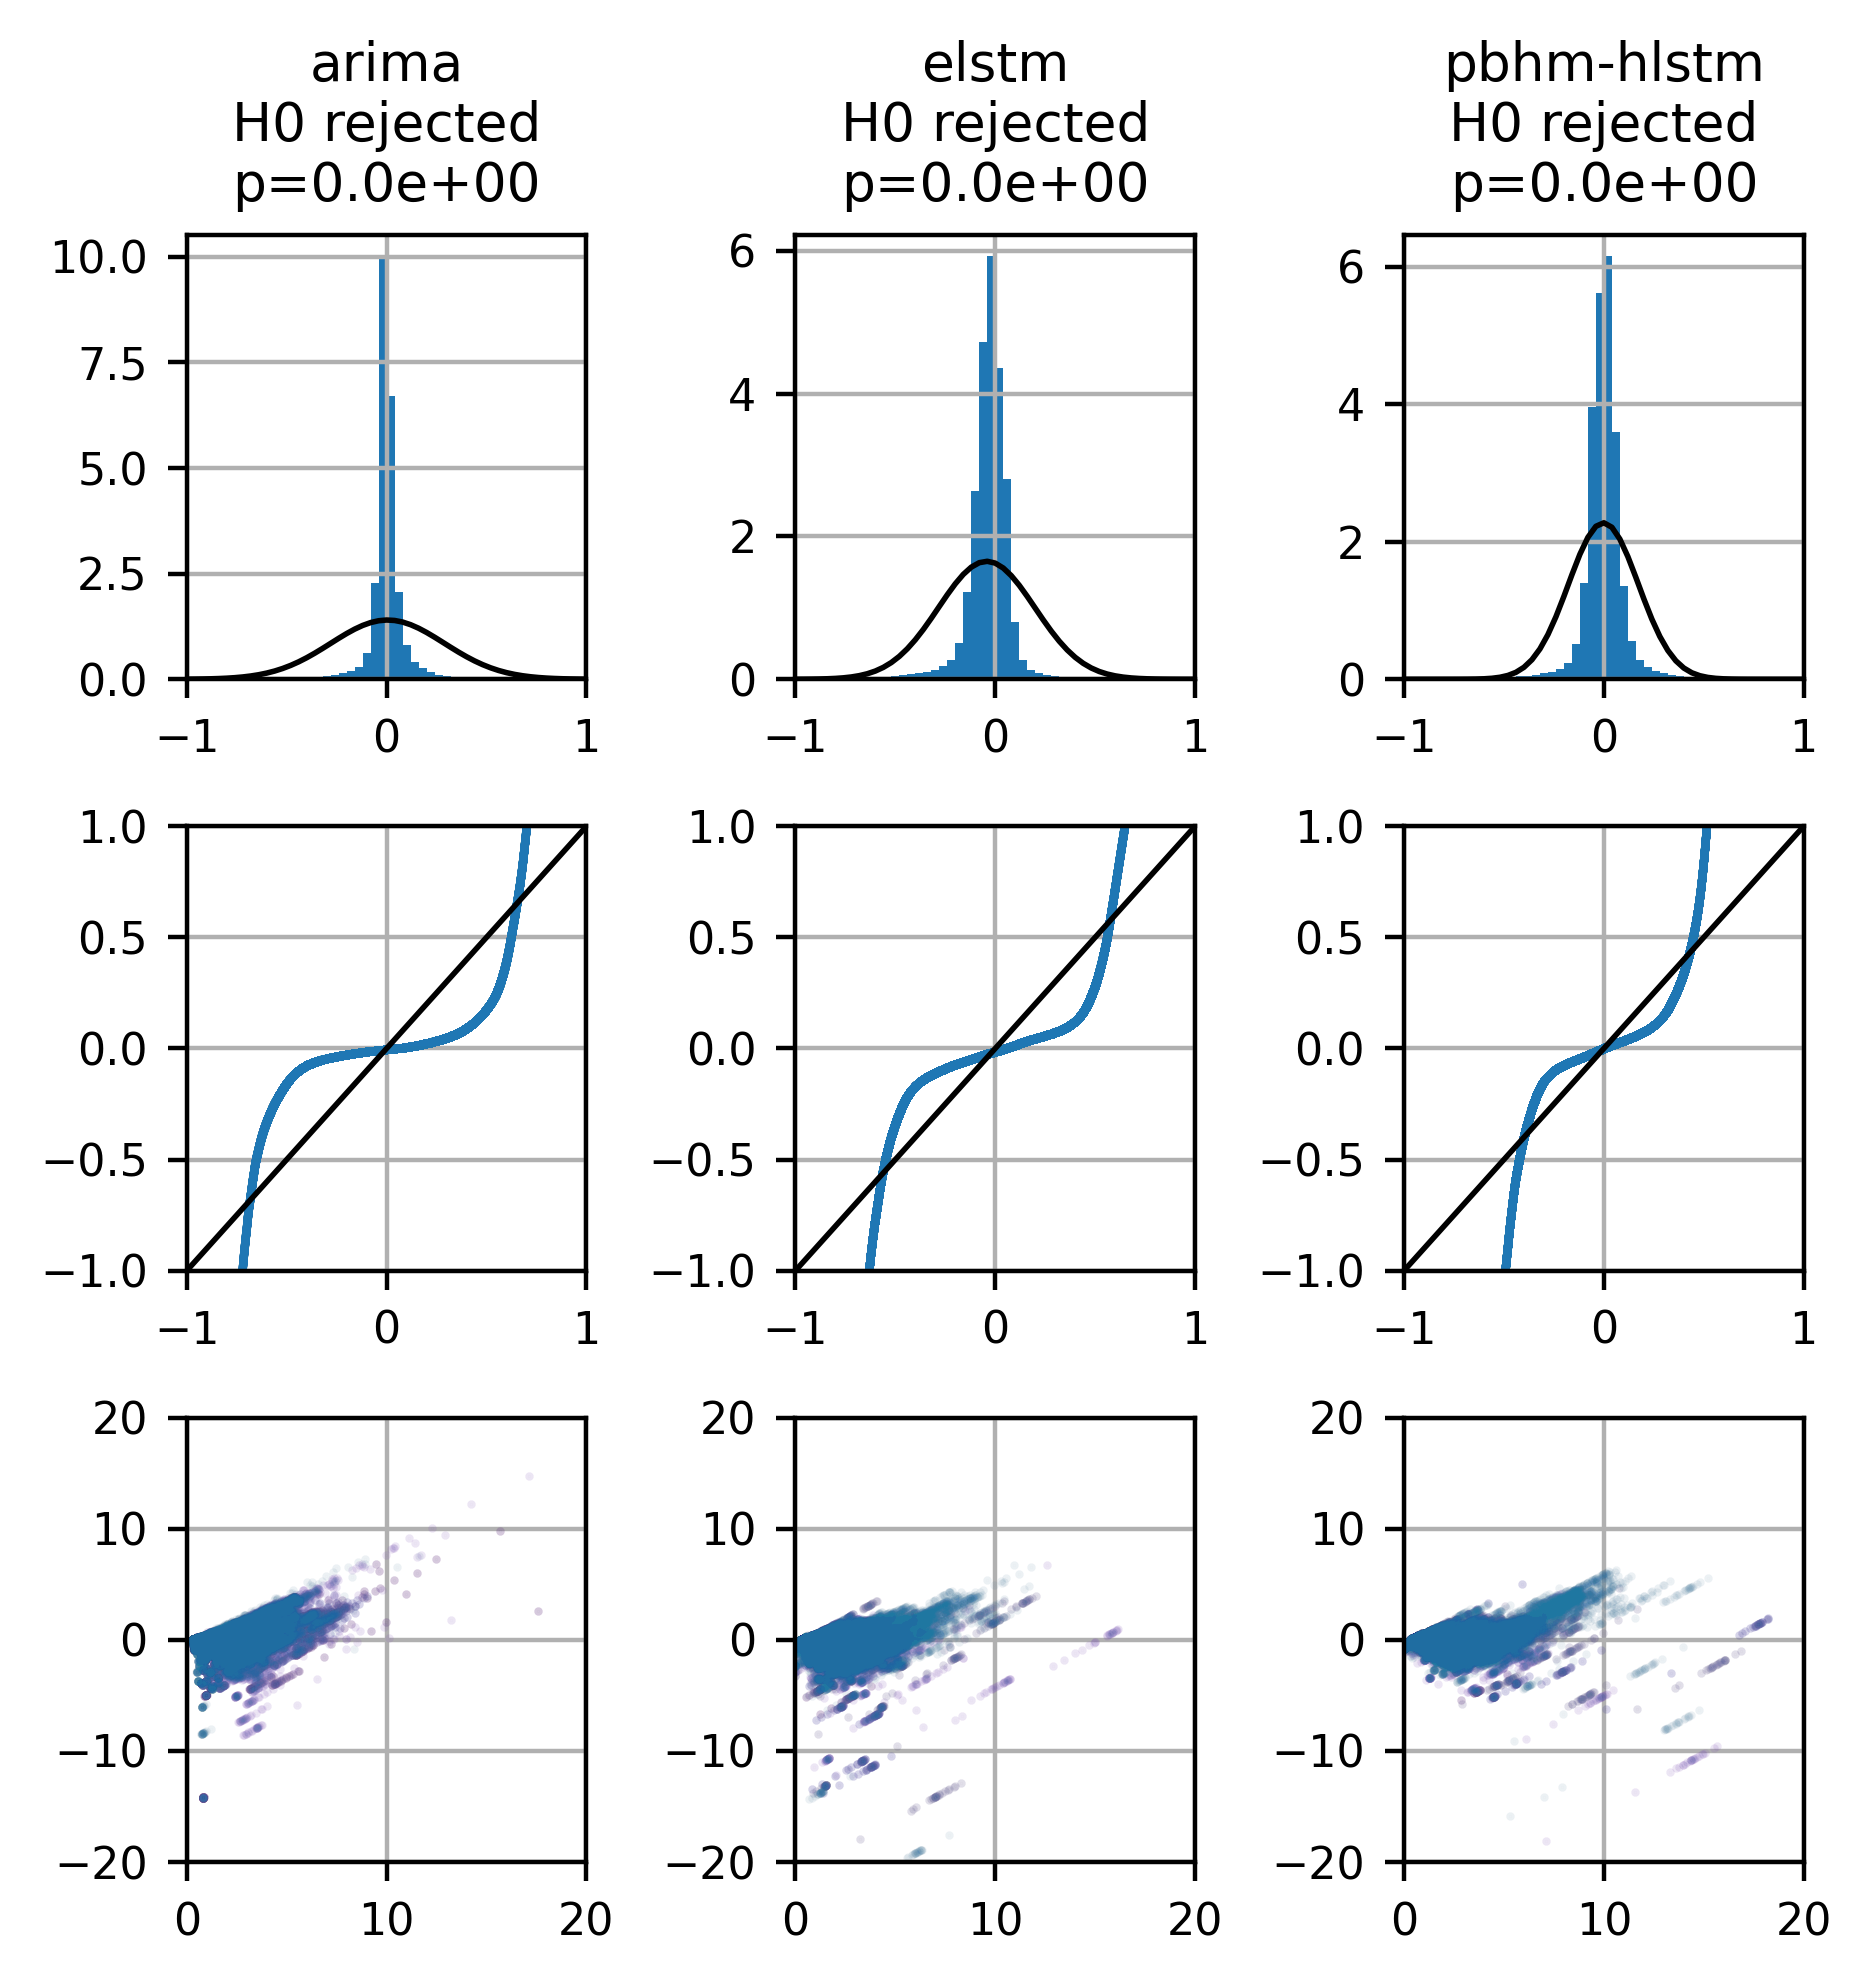

In [5]:
# define metrics to evaluate
eval_metrics = {
        "fhv" : calculate_bias_fhv,
        "flv" : calculate_bias_flv,
        "bias" : calculate_bias,
        "nse" : calculate_nse,
        "kge" : calculate_kge,
    }

colors = ["red", "blue", "green", "magenta", "gray", "black"]

fig, axes = plt.subplots(3,3,figsize=(4.72,5), dpi=400)

idx = -10
for n, key in enumerate(models.keys()):
    idx += 10
    print(key)
    
    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

    res = np.array([])
    yp_all = np.array([])
    for n_fold in range(5):
        year = 2013 + n_fold
        if models[key].is_external_model:
            # load external which come already with observations
            ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

            # get external model observations
            y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

            # get external model predictions
            yp = ext_df.filter(like="fc").values
                        
        else:
            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["train"], scale=True) 

            
            #if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
             #   yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
            #else:
                # load model
            tf.keras.backend.clear_session()
            model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

            # model prediction
            yp = model.predict(X, batch_size=1000)

        # check for normal distribution 
        res_new = (yp - y[:,:,0])[::100]
        res     = np.append(res, (yp - y[:,:,0]).flatten())
        yp_all  = np.append(yp_all, yp.flatten())

        axes[2,n].plot(yp_all[::20], res[::20], marker=".", ls="None", markersize=1, alpha=0.05, color=colors[n_fold])
    
        
    stat, p = stats.normaltest(res)

    axes[0,n].set_title(f"{key}" + '\n' + "H0 rejected" + '\n' + f"p={p:.1e}")
    hist = axes[0,n].hist(res, label=key, bins=50, range=(-1, 1), density=True)
    axes[0,n].plot(hist[1], stats.norm.pdf(hist[1], res.mean(), res.std()), color="k", lw=1)
    #stats.probplot(res.flatten(), dist="norm", plot=axes[n])
    #axes[n].legend()
    axes[0,n].grid()
    axes[0,n].set_xlim((-1,1))


    norm = np.random.normal(res.mean(),res.std(),len(res))
    axes[1,n].plot(np.sort(norm)[::20], np.sort(res)[::20], marker=".", ls="None", markersize=1, alpha=0.05)
    axes[1,n].plot([-10,10], [-10,10], marker="None", ls="-", lw=1, color="k")
    axes[1,n].grid()
    #axes[1,n].set_aspect('equal', adjustable='box')
    axes[1,n].set_xlim((-1,1))
    axes[1,n].set_ylim((-1,1))

    axes[2,n].plot(yp_all[::20], res[::20], marker=".", ls="None", markersize=1, alpha=0.05)
    axes[2,n].grid()
    axes[2,n].set_xlim((0,20))
    axes[2,n].set_ylim((-20,20))
    
fig.tight_layout()

In [6]:
fig.savefig(os.path.join(PLOT_PATH, 'residuals-fold.png'), dpi=300, bbox_inches='tight')

In [7]:
path = r"src\data\Dataset.csv"

df = pd.read_csv(path)


for col in ["qmeastrain", "qmeasval", "qsim"]:
    df[col+"_boxcox"] = stats.boxcox(df[col].values, 0.2) + 3

df.to_csv(path)

In [8]:
rst = stats.linregress(yp_all, res)
rst.slope, rst.intercept

(0.01817779719057096, -0.01881076203994736)

(0.5, 1.5)

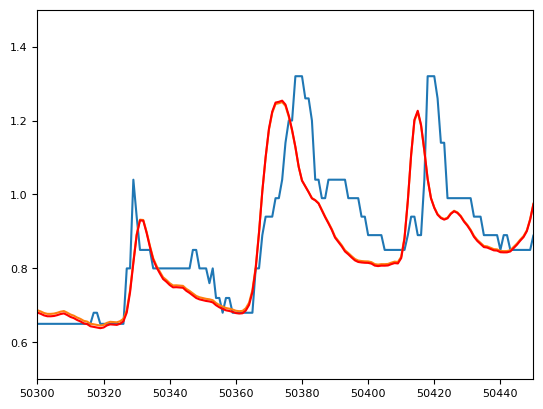

In [15]:
step = 95
plt.plot(y[:,step,0])
plt.plot(yp[:,step])
plt.plot(yp[:,step] + rst.intercept + rst.slope*yp[:,step], color="r")
plt.xlim((50300, 50450))
plt.ylim((0.5, 1.5))

In [16]:
plt.gcf().savefig(os.path.join(PLOT_PATH, 'residuals-ymeas.png'), dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>